# Developing an AI application

## Import Packages

In [1]:
import argparse
import os
import random
import warnings
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils

## Params

In [2]:
parser = {
    'nb_epoch': 10,
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_workers': 2,
    'cuda': False,
    'seed': 17122018,
    'valid_size': 0.2,
    'dataset_dir': './datasets/flower_data',
    'model_arch': 'vgg16',
    'output_dir': './',
    'checkpoint_postfix': '112019',
}

args = argparse.Namespace(**parser)
args.cuda = args.cuda and torch.cuda.is_available()

if args.cuda:
    torch.cuda.manual_seed(args.seed)
else:
    torch.manual_seed(args.seed)

In [3]:
args.train_dir = args.dataset_dir + '/train'
args.valid_dir = args.dataset_dir + '/valid'
args.checkpoint_dir = '{}{}_{}.pt'.format(args.output_dir, args.model_arch, args.checkpoint_postfix)

## Load the data

In [4]:
def check_dataset(dataroot, training=True):
    """
    Args:
        dataset (str): Name of the dataset to use. See CLI help for details
        dataroot (str): root directory where the dataset will be stored.
    Returns:
        dataset (data.Dataset): torchvision Dataset object
    """
    to_rgb = transforms.Lambda(lambda img: img.convert('RGB'))
    resize = transforms.Resize(224)
    crop = transforms.CenterCrop(224)
    flip_horizontal = transforms.RandomHorizontalFlip(p=0.4)
    gray_scale = transforms.RandomGrayscale(p=0.3)
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
    if training:
        dataset = dset.ImageFolder(root=dataroot, transform=transforms.Compose([resize,
                                                                                crop,
                                                                                flip_horizontal,
                                                                                gray_scale,
                                                                                to_tensor,
                                                                                normalize]))
    else:
        dataset = dset.ImageFolder(root=dataroot, transform=transforms.Compose([resize,
                                                                                crop,
                                                                                to_tensor,
                                                                                normalize]))
    return dataset

In [5]:
train_dataset = check_dataset(args.train_dir)
valid_dataset = check_dataset(args.valid_dir, training=False)

In [6]:
# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(args.valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [7]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=train_sampler, num_workers=args.num_workers)
valid_loader = data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=valid_sampler, num_workers=args.num_workers)
test_loader = data.DataLoader(valid_dataset, batch_size=args.batch_size, num_workers=args.num_workers)

In [8]:
next(iter(train_loader))

[tensor([[[[-1.7240, -1.7240, -1.7583,  ..., -2.0837, -2.0323, -2.0152],
           [-1.7583, -1.7583, -1.7583,  ..., -2.1008, -2.0665, -2.0494],
           [-1.7583, -1.7754, -1.7925,  ..., -2.1008, -2.0837, -2.0665],
           ...,
           [-1.2788, -1.2274, -1.1760,  ..., -1.8097, -1.8268, -1.8439],
           [-1.2788, -1.2274, -1.1932,  ..., -1.8097, -1.8268, -1.8439],
           [-1.2959, -1.2788, -1.3302,  ..., -1.7754, -1.7925, -1.7925]],
 
          [[-1.5455, -1.5630, -1.5980,  ..., -2.0007, -1.9482, -1.9307],
           [-1.5455, -1.5630, -1.6155,  ..., -2.0182, -1.9832, -1.9657],
           [-1.5805, -1.6155, -1.6506,  ..., -2.0182, -2.0007, -1.9832],
           ...,
           [-1.0728, -1.0728, -1.1779,  ..., -1.6506, -1.6681, -1.6856],
           [-1.0728, -1.0728, -1.1779,  ..., -1.6506, -1.6681, -1.6856],
           [-1.1253, -1.1253, -1.1954,  ..., -1.6155, -1.6331, -1.6331]],
 
          [[-1.6650, -1.6650, -1.6476,  ..., -1.7522, -1.7173, -1.6999],
           [-

## Visualize batch of image

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

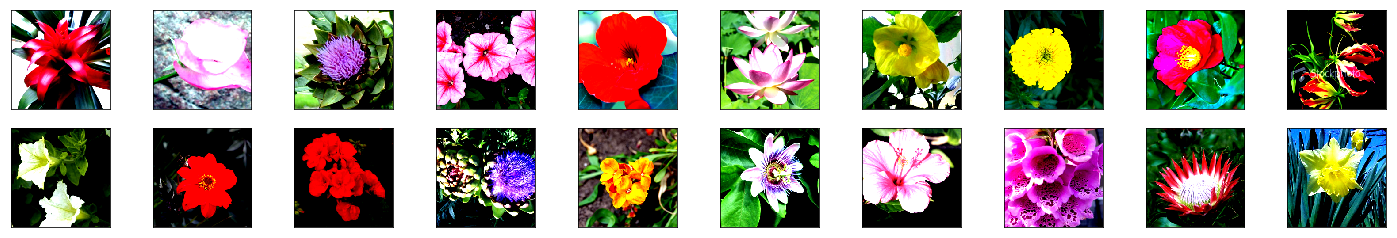

In [31]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(classes[labels[idx]])

## Label Mapping

In [72]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [73]:
cat_to_name[str(labels[1].item())]

'ruby-lipped cattleya'

In [74]:
n_classes = len(cat_to_name.keys())

## Building and training the classifier

In [88]:
def create_model(model_arch, n_classes, is_pretrained=True):
    if model_arch == 'vgg16':
        model = models.vgg16(pretrained=is_pretrained)
        # Freeze training for all "features" layers
        for param in model.features.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # add last linear layer (n_inputs -> flower classes)
        # new layers automatically have requires_grad = True
        last_layer = nn.Linear(n_inputs, n_classes)
        model.classifier[6] = last_layer
        return model
        
#     else if model_arch == 'resnet152':
#         model = models.resnet152(pretrained=is_pretrained)
    else:
        print('The model arch does not exist.')

## Training

In [77]:
def train(model, optimizer, criterion, train_loader, train_on_gpu=False):
    train_loss = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()        
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    return train_loss

In [78]:
def validate(model, criterion, valid_loader, train_on_gpu=False):
    valid_loss = 0.0
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    valid_loss = valid_loss/len(valid_loader.dataset)
    return valid_loss

In [90]:
model = create_model(args.model_arch, n_classes, is_pretrained=True)

In [94]:
#model = create_model(args.model_arch, n_classes, is_pretrained=True)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=args.learning_rate)

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, args.nb_epoch + 1):
    
    train_loss = train(model, optimizer, criterion, train_loader)
    valid_loss = validate(model, criterion, valid_loader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), args.checkpoint_dir)
        valid_loss_min = valid_loss

Traceback (most recent call last):
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/hminle/minico

KeyboardInterrupt: 